In [22]:
import cv2
import numpy as np
import os
import random
from shapely.geometry import Polygon

os.makedirs("images", exist_ok=True)
os.makedirs("labels", exist_ok=True)

IMG_SIZE = 416

SHAPES = {
    0: "circle",
    1: "rectangle",
    2: "triangle",
    3: "ellipse"
}


In [23]:
def random_color():
    return tuple(np.random.randint(0, 255, size=3).tolist())

def shape_to_polygon(shape_type, params):
    """Convert shape params to polygon (for intersection checking)."""
    if shape_type == "circle":
        cx, cy, r = params
        return Polygon([(cx + r*np.cos(a), cy + r*np.sin(a)) for a in np.linspace(0, 2*np.pi, 30)])
    elif shape_type == "rectangle":
        x, y, w, h = params
        return Polygon([(x,y), (x+w,y), (x+w,y+h), (x,y+h)])
    elif shape_type == "triangle":
        pts = params
        return Polygon(pts)
    elif shape_type == "ellipse":
        cx, cy, ax, ay = params
        return Polygon([(cx + ax*np.cos(a), cy + ay*np.sin(a)) for a in np.linspace(0, 2*np.pi, 30)])
    return None

def get_bbox(shape_type, params):
    """Return YOLO bbox (normalized x_center, y_center, w, h)."""
    if shape_type == "circle":
        cx, cy, r = params
        x_min, y_min, x_max, y_max = cx-r, cy-r, cx+r, cy+r
    elif shape_type == "rectangle":
        x, y, w, h = params
        x_min, y_min, x_max, y_max = x, y, x+w, y+h
    elif shape_type == "triangle":
        pts = np.array(params)
        x_min, y_min = pts[:,0].min(), pts[:,1].min()
        x_max, y_max = pts[:,0].max(), pts[:,1].max()
    elif shape_type == "ellipse":
        cx, cy, ax, ay = params
        x_min, y_min, x_max, y_max = cx-ax, cy-ay, cx+ax, cy+ay

    x_center = (x_min + x_max)/2 / IMG_SIZE
    y_center = (y_min + y_max)/2 / IMG_SIZE
    w = (x_max - x_min) / IMG_SIZE
    h = (y_max - y_min) / IMG_SIZE
    return x_center, y_center, w, h


In [24]:
def generate_image(idx):
    img = np.ones((IMG_SIZE, IMG_SIZE, 3), dtype=np.uint8) * 255
    label_lines = []

    num_shapes = random.randint(1, 4)
    polygons = []

    for _ in range(num_shapes):
        tries = 0
        while tries < 50:
            shape_id = random.choice(list(SHAPES.keys()))
            shape_type = SHAPES[shape_id]

            if shape_type == "circle":
                r = random.randint(20, 60)
                cx, cy = random.randint(r, IMG_SIZE-r), random.randint(r, IMG_SIZE-r)
                params = (cx, cy, r)
            elif shape_type == "rectangle":
                w, h = random.randint(30, 80), random.randint(30, 80)
                x, y = random.randint(0, IMG_SIZE-w), random.randint(0, IMG_SIZE-h)
                params = (x, y, w, h)
            elif shape_type == "triangle":
                pts = [(random.randint(0, IMG_SIZE), random.randint(0, IMG_SIZE)) for _ in range(3)]
                params = pts
            elif shape_type == "ellipse":
                ax, ay = random.randint(20, 60), random.randint(20, 60)
                cx, cy = random.randint(ax, IMG_SIZE-ax), random.randint(ay, IMG_SIZE-ay)
                params = (cx, cy, ax, ay)

            poly = shape_to_polygon(shape_type, params)

            if not any(poly.intersects(p) for p in polygons):
                polygons.append(poly)


                color = random_color()
                if shape_type == "circle":
                    cv2.circle(img, (params[0], params[1]), params[2], color, -1)
                elif shape_type == "rectangle":
                    cv2.rectangle(img, (params[0], params[1]), (params[0]+params[2], params[1]+params[3]), color, -1)
                elif shape_type == "triangle":
                    cv2.drawContours(img, [np.array(params, np.int32)], 0, color, -1)
                elif shape_type == "ellipse":
                    cv2.ellipse(img, (params[0], params[1]), (params[2], params[3]), 0, 0, 360, color, -1)


                x, y, w, h = get_bbox(shape_type, params)
                label_lines.append(f"{shape_id} {x:.6f} {y:.6f} {w:.6f} {h:.6f}")
                break
            tries += 1


    cv2.imwrite(f"images/{idx:04d}.jpg", img)
    with open(f"labels/{idx:04d}.txt", "w") as f:
        f.write("\n".join(label_lines))


In [25]:
for i in range(2000):
    generate_image(i)

print("✅ Dataset created: 2000 images with labels")


✅ Dataset created: 2000 images with labels


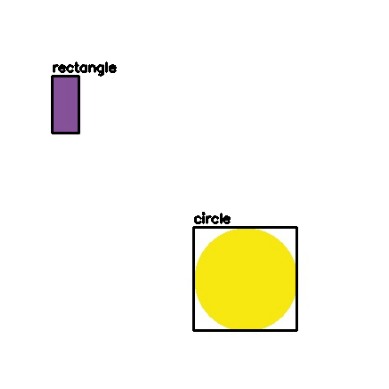

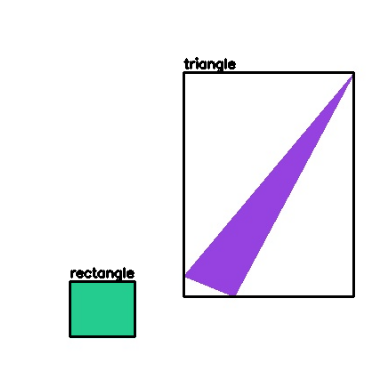

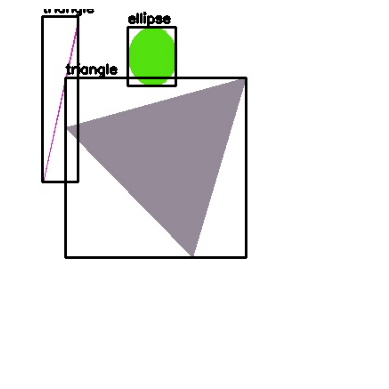

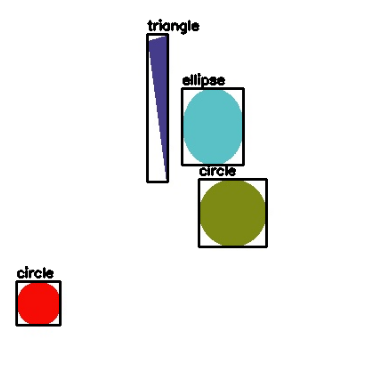

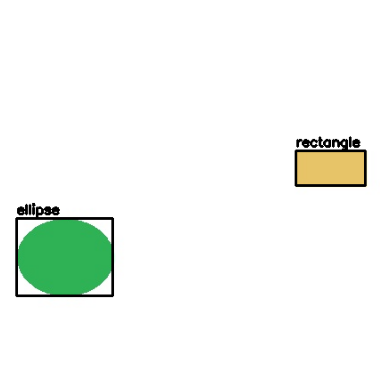

In [26]:
import matplotlib.pyplot as plt
import random

def show_samples(n=5):
    samples = random.sample(range(2000), n)
    for idx in samples:
        img = cv2.imread(f"images/{idx:04d}.jpg")
        with open(f"labels/{idx:04d}.txt") as f:
            labels = f.readlines()

        for line in labels:
            cls, x, y, w, h = map(float, line.strip().split())
            cls = int(cls)

            x1 = int((x - w/2) * IMG_SIZE)
            y1 = int((y - h/2) * IMG_SIZE)
            x2 = int((x + w/2) * IMG_SIZE)
            y2 = int((y + h/2) * IMG_SIZE)
            cv2.rectangle(img, (x1, y1), (x2, y2), (0,0,0), 2)
            cv2.putText(img, SHAPES[cls], (x1, y1-5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 2)

        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.show()


show_samples(5)


In [27]:
import zipfile

def make_zip():
    with zipfile.ZipFile("dataset.zip", "w") as zipf:
        for folder in ["images", "labels"]:
            for file in os.listdir(folder):
                zipf.write(os.path.join(folder, file))
    print(" dataset.zip created")

make_zip()


 dataset.zip created


In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
import cv2
import os
import numpy as np
from glob import glob


In [29]:
IMG_SIZE = 224
GRID_SIZE = 7
B = 2
NUM_CLASSES = 4

IMAGE_DIR = "images"
LABEL_DIR = "labels"

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


In [30]:
class ShapesDataset(Dataset):
    def __init__(self, img_dir, label_dir, transform=None):
        self.img_files = sorted(glob(os.path.join(img_dir, "*.jpg")))
        self.label_files = sorted(glob(os.path.join(label_dir, "*.txt")))
        self.transform = transform

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img = cv2.imread(self.img_files[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w, _ = img.shape


        img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        if self.transform:
            img_resized = self.transform(img_resized)


        target = torch.zeros((GRID_SIZE, GRID_SIZE, B*5 + NUM_CLASSES))
        with open(self.label_files[idx], "r") as f:
            for line in f.readlines():
                cls, x, y, bw, bh = map(float, line.strip().split())
                grid_x = int(x * GRID_SIZE)
                grid_y = int(y * GRID_SIZE)


                for b in range(B):
                    target[grid_y, grid_x, b*5:(b+1)*5] = torch.tensor([x, y, bw, bh, 1])


                target[grid_y, grid_x, B*5 + int(cls)] = 1

        return img_resized, target


In [31]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

dataset = ShapesDataset(IMAGE_DIR, LABEL_DIR, transform=transform)


train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=16, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=16, shuffle=False)

print("✅ Data ready:", len(train_ds), len(val_ds), len(test_ds))


✅ Data ready: 1400 400 200


In [32]:
model = VGG19Detector().to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [33]:
class VGG19Detector(nn.Module):
    def __init__(self, grid_size=GRID_SIZE, B=B, num_classes=NUM_CLASSES):
        super(VGG19Detector, self).__init__()
        self.grid_size = grid_size
        self.B = B
        self.num_classes = num_classes

        # Load pretrained VGG19 (without classifier)
        # For torchvision >= 0.13
        vgg = models.vgg19(weights=models.VGG19_Weights.IMAGENET1K_V1)



        self.features = vgg.features


        self.detector = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear((IMG_SIZE//32)*(IMG_SIZE//32)*1024, 4096),
            nn.ReLU(),
            nn.Linear(4096, grid_size*grid_size*(B*5 + num_classes))
        )

    def forward(self, x):
        x = self.features(x)
        out = self.detector(x)
        out = out.view(-1, self.grid_size, self.grid_size, self.B*5 + self.num_classes)
        return out


In [34]:
def yolo_loss(pred, target):
    lambda_coord = 5
    lambda_noobj = 0.5


    obj_mask = target[..., 4] > 0


    coord_loss = lambda_coord * torch.sum((pred[..., 0:2][obj_mask] - target[..., 0:2][obj_mask])**2)
    size_loss  = lambda_coord * torch.sum((pred[..., 2:4][obj_mask] - target[..., 2:4][obj_mask])**2)


    conf_loss = torch.sum((pred[..., 4] - target[..., 4])**2) * lambda_noobj


    class_loss = torch.sum((pred[..., 5:] - target[..., 5:])**2)

    total_loss = coord_loss + size_loss + conf_loss + class_loss
    return total_loss


In [35]:
# Create folder for saving models
os.makedirs("checkpoints", exist_ok=True)

EPOCHS = 50
train_losses, val_losses = [], []
best_val_loss = float("inf")  # start with infinity

for epoch in range(EPOCHS):
    # ---- Training ----
    model.train()
    running_train_loss = 0
    for imgs, targets in train_loader:
        imgs, targets = imgs.to(DEVICE), targets.to(DEVICE)

        preds = model(imgs)
        loss = yolo_loss(preds, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # ---- Validation ----
    model.eval()
    running_val_loss = 0
    with torch.no_grad():
        for imgs, targets in val_loader:
            imgs, targets = imgs.to(DEVICE), targets.to(DEVICE)
            preds = model(imgs)
            running_val_loss += yolo_loss(preds, targets).item()

    avg_val_loss = running_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch [{epoch+1}/{EPOCHS}] | "
          f"Train Loss: {avg_train_loss:.4f} | "
          f"Val Loss: {avg_val_loss:.4f}")

    # ---- Save Best Model ----
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), "checkpoints/best_model.pth")
        print("💾 Best model saved at epoch", epoch+1)


Epoch [1/50] | Train Loss: 135.7234 | Val Loss: 110.4748
💾 Best model saved at epoch 1
Epoch [2/50] | Train Loss: 89.0497 | Val Loss: 74.0947
💾 Best model saved at epoch 2
Epoch [3/50] | Train Loss: 56.5179 | Val Loss: 61.7537
💾 Best model saved at epoch 3
Epoch [4/50] | Train Loss: 43.9190 | Val Loss: 50.7251
💾 Best model saved at epoch 4
Epoch [5/50] | Train Loss: 32.7755 | Val Loss: 47.9089
💾 Best model saved at epoch 5
Epoch [6/50] | Train Loss: 24.9427 | Val Loss: 45.0893
💾 Best model saved at epoch 6
Epoch [7/50] | Train Loss: 20.9879 | Val Loss: 45.5057
Epoch [8/50] | Train Loss: 18.6563 | Val Loss: 43.7427
💾 Best model saved at epoch 8
Epoch [9/50] | Train Loss: 14.0595 | Val Loss: 42.5254
💾 Best model saved at epoch 9
Epoch [10/50] | Train Loss: 11.8267 | Val Loss: 41.6611
💾 Best model saved at epoch 10
Epoch [11/50] | Train Loss: 10.8995 | Val Loss: 40.2534
💾 Best model saved at epoch 11
Epoch [12/50] | Train Loss: 8.9402 | Val Loss: 40.3895
Epoch [13/50] | Train Loss: 7.7551

In [36]:
def iou(box1, box2):
    """
    box format: [x_center, y_center, w, h] (normalized 0-1)
    """

    x1_min = box1[0] - box1[2]/2
    y1_min = box1[1] - box1[3]/2
    x1_max = box1[0] + box1[2]/2
    y1_max = box1[1] + box1[3]/2

    x2_min = box2[0] - box2[2]/2
    y2_min = box2[1] - box2[3]/2
    x2_max = box2[0] + box2[2]/2
    y2_max = box2[1] + box2[3]/2

    inter_xmin = max(x1_min, x2_min)
    inter_ymin = max(y1_min, y2_min)
    inter_xmax = min(x1_max, x2_max)
    inter_ymax = min(y1_max, y2_max)

    inter_area = max(0, inter_xmax - inter_xmin) * max(0, inter_ymax - inter_ymin)
    box1_area = (x1_max - x1_min) * (y1_max - y1_min)
    box2_area = (x2_max - x2_min) * (y2_max - y2_min)

    union = box1_area + box2_area - inter_area
    return inter_area / union if union > 0 else 0


In [37]:
def evaluate(model, loader, iou_threshold=0.1):
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for imgs, targets in loader:
            imgs, targets = imgs.to(DEVICE), targets.to(DEVICE)
            preds = model(imgs)


            for b in range(imgs.shape[0]):
                pred_grid = preds[b].cpu().numpy()
                target_grid = targets[b].cpu().numpy()


                for gy in range(GRID_SIZE):
                    for gx in range(GRID_SIZE):
                        if target_grid[gy, gx, 4] > 0:
                            total += 1


                            true_box = target_grid[gy, gx, 0:4]
                            true_class = np.argmax(target_grid[gy, gx, B*5:])


                            best_iou, best_pred_class = 0, -1
                            for b_idx in range(B):
                                pred_box = pred_grid[gy, gx, b_idx*5:(b_idx*5)+4]
                                pred_conf = pred_grid[gy, gx, b_idx*5+4]
                                pred_cls = np.argmax(pred_grid[gy, gx, B*5:])

                                iou_score = iou(pred_box, true_box)
                                if iou_score > best_iou:
                                    best_iou = iou_score
                                    best_pred_class = pred_cls

                            if best_iou >= iou_threshold and best_pred_class == true_class:
                                correct += 1

    acc = correct / total if total > 0 else 0
    print(f"✅ Test Accuracy: {acc*100:.2f}% (IoU ≥ {iou_threshold})")
    return acc


In [38]:
test_acc = evaluate(model, test_loader, iou_threshold=0.1)


✅ Test Accuracy: 85.60% (IoU ≥ 0.1)


In [39]:
import matplotlib.pyplot as plt


CLASS_NAMES = ["circle", "rectangle", "triangle", "ellipse"]

def plot_predictions(model, loader, num_images=5, iou_threshold=0.5):
    model.eval()
    imgs_shown = 0

    with torch.no_grad():
        for imgs, targets in loader:
            imgs, targets = imgs.to(DEVICE), targets.to(DEVICE)
            preds = model(imgs)

            for i in range(imgs.shape[0]):
                if imgs_shown >= num_images:
                    return

                img = imgs[i].cpu().permute(1,2,0).numpy()
                img = (img*255).astype("uint8").copy()

                pred_grid = preds[i].cpu().numpy()
                target_grid = targets[i].cpu().numpy()

                # ----- Ground Truth -----
                for gy in range(GRID_SIZE):
                    for gx in range(GRID_SIZE):
                        if target_grid[gy, gx, 4] > 0:
                            true_box = target_grid[gy, gx, 0:4]
                            true_class = np.argmax(target_grid[gy, gx, B*5:])

                            # Convert normalized xywh to pixels
                            x, y, w, h = true_box
                            x, y, w, h = x*IMG_SIZE, y*IMG_SIZE, w*IMG_SIZE, h*IMG_SIZE
                            x1, y1 = int(x - w/2), int(y - h/2)
                            x2, y2 = int(x + w/2), int(y + h/2)

                            cv2.rectangle(img, (x1,y1), (x2,y2), (0,255,0), 2)
                            cv2.putText(img, f"GT: {CLASS_NAMES[true_class]}",
                                        (x1, y1-5), cv2.FONT_HERSHEY_SIMPLEX,
                                        0.5, (0,255,0), 2)

                # ----- Predictions -----
                for gy in range(GRID_SIZE):
                    for gx in range(GRID_SIZE):
                        # choose best of B boxes
                        best_iou, best_box, best_class = 0, None, None
                        for b_idx in range(B):
                            pred_box = pred_grid[gy, gx, b_idx*5:(b_idx*5)+4]
                            pred_conf = pred_grid[gy, gx, b_idx*5+4]
                            pred_cls = np.argmax(pred_grid[gy, gx, B*5:])

                            if pred_conf > 0.5:  # confidence threshold
                                best_box = pred_box
                                best_class = pred_cls

                        if best_box is not None:
                            x, y, w, h = best_box
                            x, y, w, h = x*IMG_SIZE, y*IMG_SIZE, w*IMG_SIZE, h*IMG_SIZE
                            x1, y1 = int(x - w/2), int(y - h/2)
                            x2, y2 = int(x + w/2), int(y + h/2)

                            cv2.rectangle(img, (x1,y1), (x2,y2), (255,0,0), 2)
                            cv2.putText(img, f"Pred: {CLASS_NAMES[best_class]}",
                                        (x1, y2+15), cv2.FONT_HERSHEY_SIMPLEX,
                                        0.5, (255,0,0), 2)

                # show image
                plt.figure(figsize=(5,5))
                plt.imshow(img)
                plt.axis("off")
                plt.show()

                imgs_shown += 1


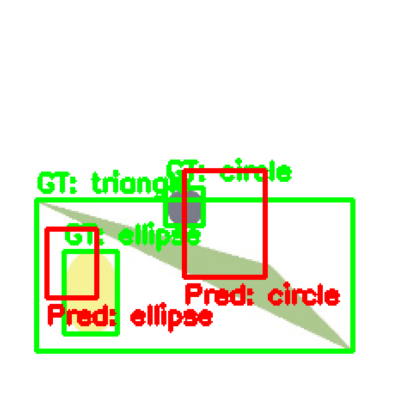

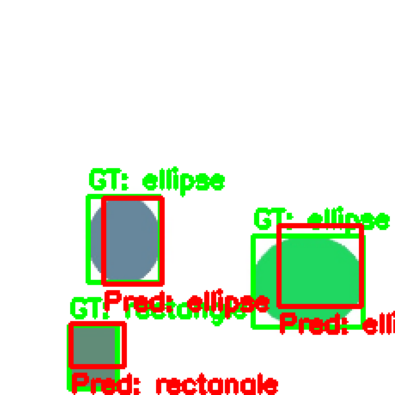

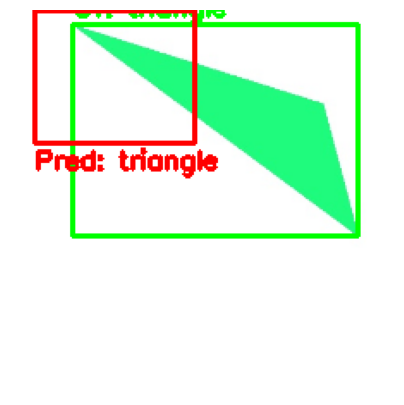

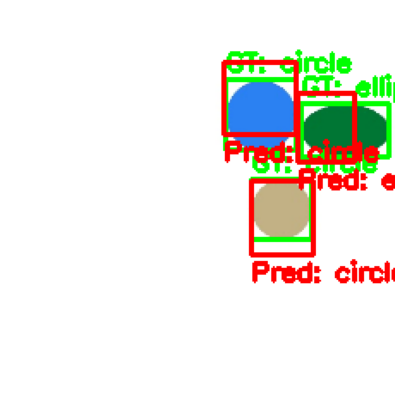

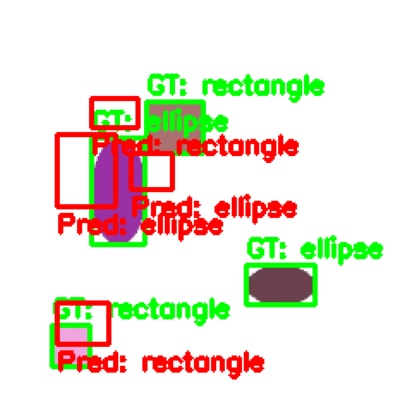

In [40]:
plot_predictions(model, test_loader, num_images=5)


In [58]:
# Load best model
model = VGG19Detector().to(DEVICE)
model.load_state_dict(torch.load("checkpoints/best_model.pth", map_location=DEVICE))
model.eval()


VGG19Detector(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1